In [1]:
import pandas as pd
import openai
import os
from openai.embeddings_utils import cosine_similarity, get_embedding
from transformers import pipeline
import numpy as np
import tiktoken
import matplotlib.pyplot as plt
openai.api_key = os.getenv('OPENAI_API_KEY')

Write text description for each label

In [2]:
labeles_dic={
"E1":"Climate Change. Transition plan, policies, actions, resources and targets relating to climate change. Energy consumption, Scope 1, 2, 3 and total GHG emissions and Greenhouse gass removal. Carbon pricing and financial effects related to climate change ",
"E2":"Pollution. Policies, Actions and Targets related to pollution. Polluition of air, water and soil. Substances of concern and potential financial effects from pollution",
"E3":"Water and marine resources. Policies, Actions and Targets related to water and marine resources. Water consumption. Financial effects relating to water and marine resources",
"E4":"Biodiversity and ecosystems. Transition plan, policies, actions, resources and targets related to biodiversity and ecosystems. Impact to biodiversity and ecosystems. Financial effects related to biodiversity and ecosystems",
"E5":"Resource use and circular economy.Policies, Actions and Targets related to recycling. Resources inflows and Resource outflows. Finantial effects related to Resource use and circular economy",
"S1":"Own workforce. Policies, processes for engagment and action to remidiate negative impact on own workforce. Charactersitics of employees and non-employees. Collective barganing, diversity, adequate wage, social protection, traning and health and worklife balance indicators. Compensation and incident reporting",
"S2":"Workers in the value chain. Policies, targets, processes for engagment and action to remidiate negative impact on Workers in the value chain",
"S3":"Affected communities. Policies, processes for engaging and remidiating negative impact for Affected communities. Action and targets related to affected communities",
"S4":"Consumers and end-users. Policies, processes for engaging and remidiating negative impact for Consumers and end-users. Action and targets related to Consumers and end-users",
"G1":"Business Conduct. Corporate culture and business conduct policies, relationship with suppliers. Prevention and detection of curroption or bribery. Political influence and lobbying. Payment practices "}


In [3]:
labels=list(labeles_dic.values())# label description
CRSD_Lables=list(labeles_dic.keys())# list of labels
# get embeddings for each labal
label_embeddings = [openai.Embedding.create(input=[i], model='text-embedding-ada-002')['data'][0]['embedding'] for i in labels]

In [4]:
# this function takes in list of similarity scores and returns them in desending order with the coresponding label
def sorted_embedings(sim):
    results_list=[]       
    for i in range(0,len(CRSD_Lables)):
        results_list.append([CRSD_Lables[i],sim[i]])
    results_list.sort(key = lambda i: i[1],reverse = True)
    return results_list

In [5]:
# read test data
df=pd.read_csv("..\\MJ_test_set_labeld.csv",index_col=0)
df=df.reset_index(drop=True)

In [6]:
# get embeding for text in text data
data_embeddings=[]
for i in range(0,len(df)):
    data_embeddings+=[openai.Embedding.create(input = df.Text.at[i], model='text-embedding-ada-002')['data'][0]['embedding']]
    i+=1

In [7]:
# get text emebeddings and associated label
zero_shot_resluts=[]
for i in range(0,len(data_embeddings)):
    sim = [cosine_similarity(data_embeddings[i], j) for j in label_embeddings]
    zero_shot_resluts.append(sorted_embedings(sim))

In [8]:
# get softmax score
from scipy.special import softmax
softmax_array=[]
for i in range(0,len(zero_shot_resluts)):
    array=[]
    for j in range(0,10):
        array.append(zero_shot_resluts[i][j][1])
    softmax_array.append(softmax(array))

In [9]:
df["zero_shot_results"]=zero_shot_resluts
df["softmax_score"]=softmax_array

In [10]:
# get top label its similarity and softmax scores
top_rezult_label=[]
top_rezult_sim=[]
top_rezult_soft_max=[]
for i in range(0,len(df)):
    top_rezult_label.append(zero_shot_resluts[i][0][0])
    top_rezult_sim.append(zero_shot_resluts[i][0][1])
    top_rezult_soft_max.append(softmax_array[i][0])

In [11]:
# add data to dataframe
df_top_score=df.copy()
df_top_score["zero_shot_label"]=top_rezult_label
df_top_score["sim_score"]=top_rezult_sim
df_top_score["softmax_score"]=top_rezult_soft_max
df_top_score['Level_2Label_MJ'] = df_top_score.Label.str[:2]
df_top_score=df_top_score.drop(columns=["zero_shot_results","Label"])

In [12]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(df_top_score.Level_2Label_MJ, df_top_score.zero_shot_label)

0.6155381526575947

In [13]:
# use different trhesholds for similarity score and get cohen kappa for data over this trheshold
i=0.7
optimal_score=[]
while i < df_top_score["sim_score"].max():
    df_test=df_top_score[df_top_score["sim_score"]>i]
    optimal_score.append([cohen_kappa_score(df_test.Level_2Label_MJ, df_test.zero_shot_label),i,len(df_test)/len(df_top_score)])
    i+=0.001

c:\Users\PCMC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:638: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


In [14]:
optimal_score_df=pd.DataFrame(optimal_score,columns=["cohen_kappa","sim_threshold","df_remaining"])
optimal_score_df.head()

,cohen_kappa,sim_threshold,df_remaining
0,0.615538,0.700,1.0
1,0.615538,0.701,1.0
2,0.615538,0.702,1.0
3,0.615538,0.703,1.0
4,0.615538,0.704,1.0


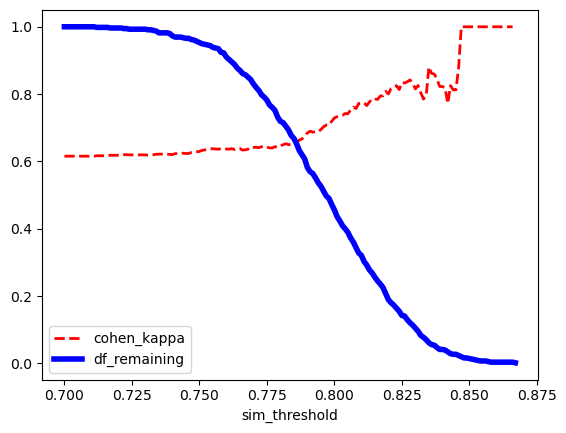

In [15]:
fig, ax = plt.subplots()
optimal_score_df.plot.line(ax = ax, x ='sim_threshold',y = 'cohen_kappa', color = 'r', linewidth = 2, linestyle ='dashed')
optimal_score_df.plot.line(ax = ax, x ='sim_threshold', y = 'df_remaining', color = 'b', linewidth= 4, linestyle = 'solid')
plt.show()

In [16]:
df_top_score['equal'] = (df_top_score['zero_shot_label']==df_top_score['Level_2Label_MJ']).astype(int)

In [17]:
df_top_score.equal.mean()# accuracy

0.6810810810810811

In [18]:
df_top_score.groupby('Level_2Label_MJ')["equal"].mean() # accuracy per class

Level_2Label_MJ
0     0.000000
E1    0.970874
E2    0.555556
E3    0.809524
E4    0.636364
E5    0.677419
G1    0.685714
S1    0.822485
S2    0.476190
S3    0.344828
S4    0.428571
Name: equal, dtype: float64

In [19]:
df_top_score.groupby('zero_shot_label')["equal"].mean()

zero_shot_label
E1    0.709220
E2    0.714286
E3    0.809524
E4    0.933333
E5    0.807692
G1    0.470588
S1    0.858025
S2    0.270270
S3    0.909091
S4    0.346154
Name: equal, dtype: float64

In [20]:
pd.crosstab(df_top_score.Level_2Label_MJ, df_top_score.zero_shot_label)

zero_shot_label,E1,E2,E3,E4,E5,G1,S1,S2,S3,S4
Level_2Label_MJ,,,,,,,,,,
0,16,0,1,0,1,15,9,4,0,4
E1,100,0,0,0,1,0,1,0,0,1
E2,5,10,1,1,0,1,0,0,0,0
E3,0,2,17,0,1,0,0,0,1,0
E4,3,0,1,14,1,1,1,1,0,0
E5,3,1,0,0,21,0,0,0,0,6
G1,5,1,0,0,1,48,5,9,0,1
S1,7,0,0,0,0,14,139,9,0,0
S2,0,0,0,0,0,9,2,10,0,0


<AxesSubplot:>

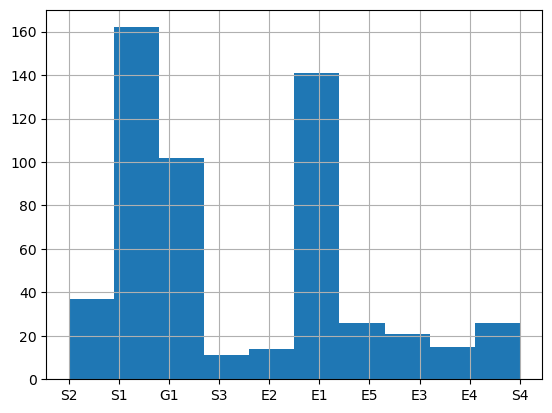

In [46]:
%matplotlib inline
df_top_score.zero_shot_label.hist(bins=10)

<AxesSubplot:>

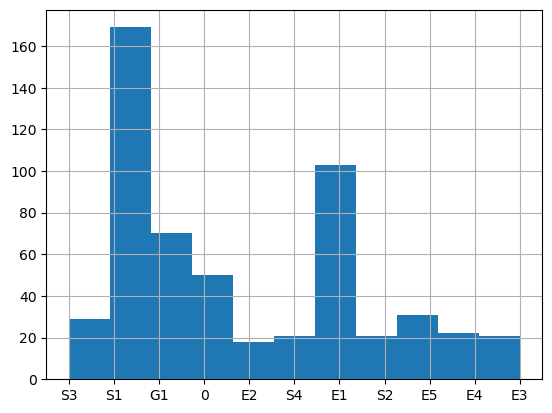

In [47]:
df_top_score.Level_2Label_MJ.hist(bins=11)

We reapeat the trheshold process for softmax score

In [23]:
i=0.1
optimal_score_softmax=[]
while i < df_top_score["softmax_score"].max():
    df_test_softmax=df_top_score[df_top_score["softmax_score"]>i]
    optimal_score_softmax.append([cohen_kappa_score(df_test_softmax.Level_2Label_MJ, df_test_softmax.zero_shot_label),i,len(df_test_softmax)/len(df_top_score)])
    i+=0.0001


c:\Users\PCMC\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:638: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


In [24]:
optimal_score_softmax_df=pd.DataFrame(optimal_score_softmax,columns=["cohen_kappa","soft_max_threshold","df_remaning"])

In [26]:
optimal_score_softmax_df["soft_max_threshold"].corr(optimal_score_softmax_df["cohen_kappa"])

0.7616116009242366

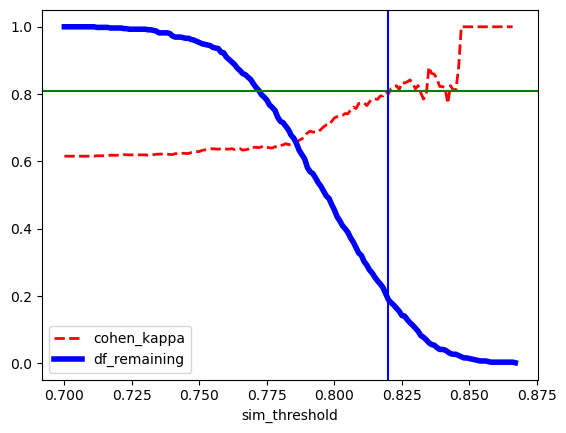

In [27]:
fig, ax = plt.subplots()
optimal_score_df.plot.line(ax = ax, x ='sim_threshold',y = 'cohen_kappa', color = 'r', linewidth = 2, linestyle ='dashed')
optimal_score_df.plot.line(ax = ax, x ='sim_threshold', y = 'df_remaining', color = 'b', linewidth= 4, linestyle = 'solid')
plt.axhline(y = 0.81, color = 'g', linestyle = '-')
plt.axvline(x = 0.82, color = 'b', label = 'axvline - full height')
plt.show()

In [28]:
df_topscore_82=df_top_score[df_top_score["sim_score"]>=0.82]

In [29]:
print("Cohen Kappa for 0.82 trheshold =",cohen_kappa_score(df_topscore_82.Level_2Label_MJ, df_topscore_82.zero_shot_label))
print("Accuracy for 0.82 trheshold =",df_topscore_82.equal.mean())
print("Data remaning  =",len(df_topscore_82)/len(df_top_score))

Cohen Kappa for 0.82 trheshold = 0.8004276550249465
Accuracy for 0.82 trheshold = 0.8476190476190476
Data remaning  = 0.1891891891891892


In [30]:
df_topscore_82.groupby('Level_2Label_MJ')["equal"].mean()

Level_2Label_MJ
0     0.000000
E1    0.976190
E2    0.500000
E3    1.000000
E4    0.833333
E5    1.000000
G1    0.818182
S1    0.952381
S2    0.571429
S3    0.250000
S4    0.000000
Name: equal, dtype: float64

In [31]:
df_topscore_82.groupby('zero_shot_label')["equal"].mean()

zero_shot_label
E1    0.931818
E2    1.000000
E3    0.666667
E4    0.833333
E5    1.000000
G1    0.642857
S1    0.869565
S2    0.666667
S3    1.000000
S4    0.000000
Name: equal, dtype: float64

<AxesSubplot:>

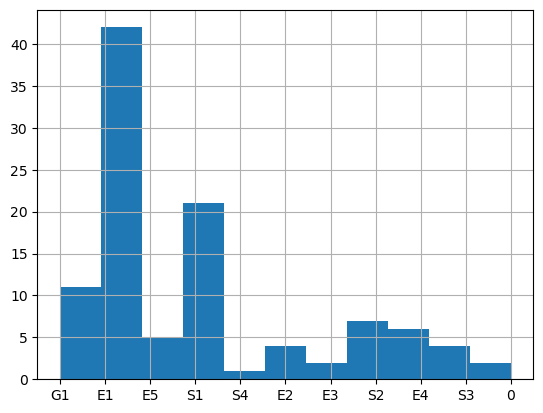

In [48]:
df_topscore_82.Level_2Label_MJ.hist(bins=11)

<AxesSubplot:>

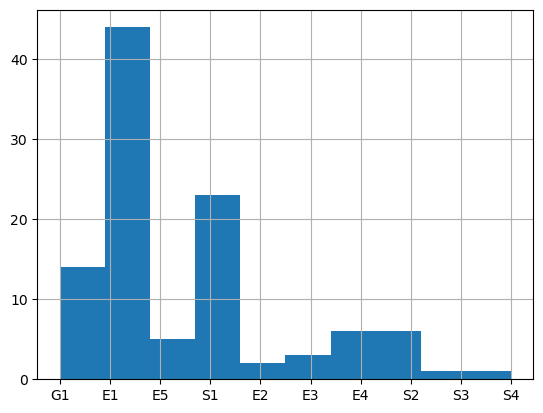

In [49]:
df_topscore_82.zero_shot_label.hist(bins=10)

In [44]:
df_topscore_82.groupby('Level_2Label_MJ').count()

,Text,softmax_score,zero_shot_label,sim_score,equal
Level_2Label_MJ,,,,,
0,2,2,2,2,2
E1,42,42,42,42,42
E2,4,4,4,4,4
E3,2,2,2,2,2
E4,6,6,6,6,6
E5,5,5,5,5,5
G1,11,11,11,11,11
S1,21,21,21,21,21
S2,7,7,7,7,7


<AxesSubplot:>

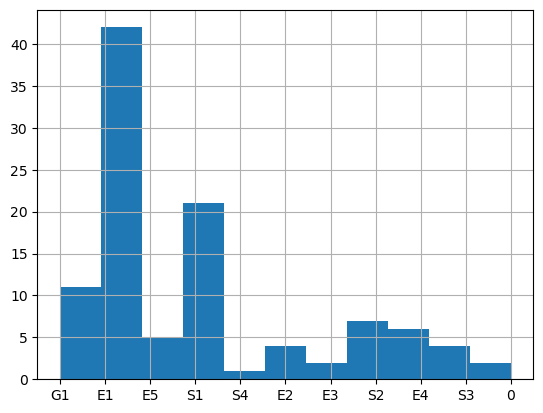

In [50]:
df_topscore_82.Level_2Label_MJ.hist(bins=11)

In [51]:
softmax_array_top3=[]
for i in range(0,len(zero_shot_resluts)):
    array=[]
    for j in range(0,3):
        array.append(zero_shot_resluts[i][j][1])
    softmax_array_top3.append(softmax(array))

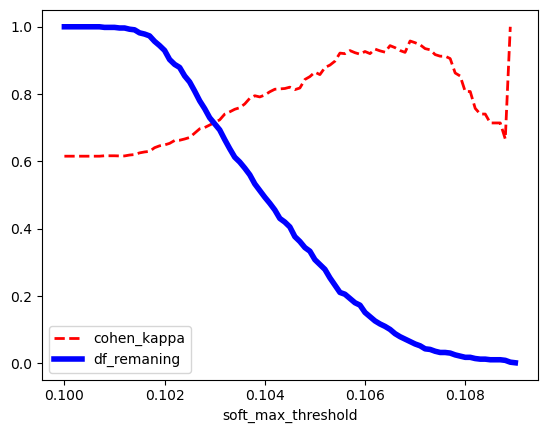

In [53]:
fig, ax = plt.subplots()
optimal_score_softmax_df.plot.line(ax = ax, x ='soft_max_threshold',y = 'cohen_kappa', color = 'r', linewidth = 2, linestyle ='dashed')
optimal_score_softmax_df.plot.line(ax = ax, x ='soft_max_threshold', y = 'df_remaning', color = 'b', linewidth= 4, linestyle = 'solid')
plt.show()